In [19]:
%matplotlib inline
import numpy as np
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, LinearTriInterpolator
from scipy.interpolate import splrep, splev, splprep, interp1d
from scipy.optimize import curve_fit
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from decimal import Decimal
import scipy
from scipy import special
from scipy.integrate import trapz, simps
import I_n_P as P
from importlib import reload
plt.style.use('ggplot')
path = 'C:\\WINDOWS\\Fonts\\BOOKOS.TTF'
prop = fm.FontProperties(fname=path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}',
          r'\usepackage{xfrac}']

In [20]:
reload(P)

<module 'I_n_P' from 'C:\\Users\\giannis\\Desktop\\Python_scrpts\\I_n_P.py'>

We start by calculating the equilibrium fluxes using values of density and potential obtained through parallel loading of patches and interpolation. Further down, we repeat the calculation using only separatrix computational nodes.

In [21]:
'''Reading in all values'''
angle_B,Bp,B = P.magnetic_read()
angle_phi, phi, _ = P.phis_read()
angle_den, den = P.density_read()
angle_ddr,_,_,_,R_s,Z_s = P.exb_read()

In [22]:
'''Performing theta interpolations of values.'''
Bp = P.angle_interp(angle_B,Bp,1,smo=False) #We shouldnt smooth geometric and magnetic field quantities.
B = P.angle_interp(angle_B,B,1,smo=False)
phi = P.angle_interp(angle_phi,phi,30,smo=True)
den = P.angle_interp(angle_den,den,30,smo=True)
R_s = P.angle_interp(angle_ddr,R_s,1)
Z_s = P.angle_interp(angle_ddr,Z_s,1)
angle = [x for x in range(0,360,1)]

In [23]:
'''Calculating some geometric quantities.'''
r_s,R_maj_s = P.major_R(R_s,Z_s) #minor and major radius.
J_inv = P.inv_Jac(Bp,r_s,angle) #inverse Jacobian.
Bzeta = np.sqrt(B**2 - Bp**2) #zeta comp of B.
B_factor = P.B_factor(Bzeta,B)
F = P.F_function(R_maj_s, Bzeta) #B = F \nabla \zeta + \nabla \Psi \times \nabla \zeta.
R_Bp_B2 = np.power(B,2) * R_maj_s * Bp #geometric factor to divide in order to make correct flux, cf. notes.

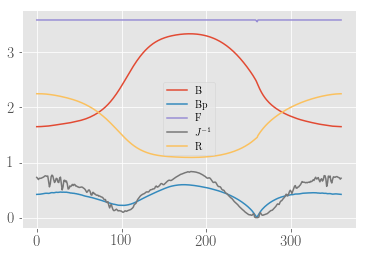

In [24]:
'''Plotting geometric quantites and magnetic fields.'''
plt.figure()
plt.plot(angle, B, label = 'B')
plt.plot(angle, Bp, label = 'Bp')
plt.plot(angle, F, label = 'F')
plt.plot(angle, J_inv, label = r'$J^{-1}$')
plt.plot(angle, R_maj_s, label = 'R')
#plt.plot(angle, R_Bp_B2, label = 'div factor')
plt.legend()
plt.show()

No handles with labels found to put in legend.


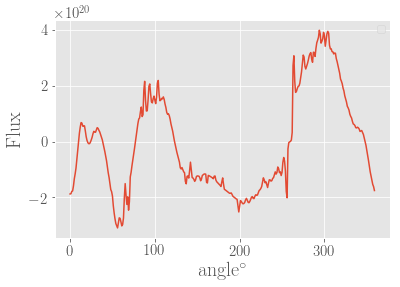

In [25]:
'''Calculation of exb equilibrium flux.'''
dphidth = P.ddtheta_even(angle, phi) #theta derivative on even grid.
Eq_dth = - (den*F*J_inv*dphidth)/(R_Bp_B2) #equilibrium exb flux.

'''Plotting of equilibrium flux.'''
plt.plot(angle[:], Eq_dth[:])
plt.ylabel('Flux')
plt.xlabel(r'angle$^{\circ}$')
plt.legend(loc=1)
plt.show()

C:\Users\giannis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


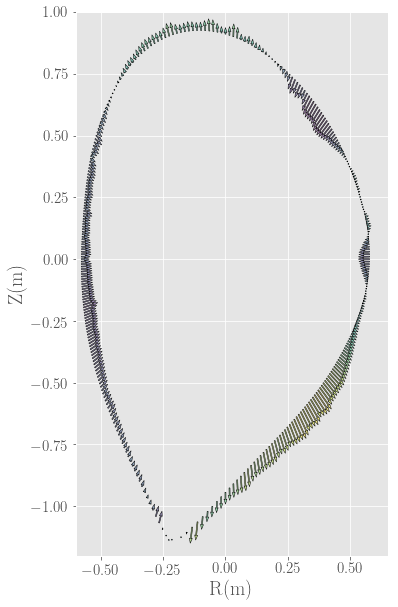

In [26]:
'''Equilibrium ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Eqx,Eqy = Eq_dth*np.cos(new_an), Eq_dth*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s, Z_s, Eqx, Eqy, Eq_dth, alpha=.5)
plt.quiver(R_s, Z_s, Eqx, Eqy, edgecolor='k', facecolor='None', linewidth=.5)
plt.xlabel('R(m)')
plt.ylabel('Z(m)')
plt.xlim(-0.6,0.65)
plt.ylim(-1.2,1.0)
plt.axes().set_aspect(0.99)
plt.show()

C:\Users\giannis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


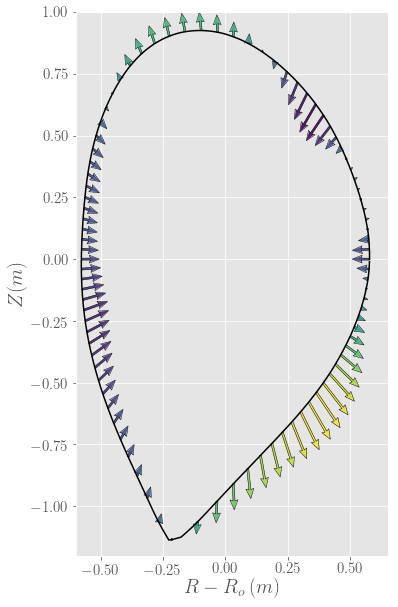

In [27]:
'''Smoothed Equilibrium ExB Flux.'''
s_eq = P.smooth(Eq_dth,10)
new_an = np.arctan2(Z_s,R_s)
Eqx,Eqy = s_eq*np.cos(new_an), s_eq*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], s_eq[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('$Z(m)$')
plt.xlim(-0.6,0.65)
plt.ylim(-1.2,1.0)
plt.axes().set_aspect(0.99)
plt.show()

Calculation of equilibrium and turbulent fluxes using values on the computational nodes.

In [28]:
reload(P)

<module 'I_n_P' from 'C:\\Users\\giannis\\Desktop\\Python_scrpts\\I_n_P.py'>

In [29]:
'''Reads arrays needed for turbulent flux calculation.'''
R_nodes = np.load('C:\\Users\\giannis\\Desktop\\Python_scrpts\\ti255\\ti255_R_sep.npy')
Z_nodes = np.load('C:\\Users\\giannis\\Desktop\\Python_scrpts\\ti255\\ti255_Z_sep.npy')
pot = np.load('C:\\Users\\giannis\\Desktop\\Python_scrpts\\ti255\\ti255_phi.npy')
n = np.load('C:\\Users\\giannis\\Desktop\\Python_scrpts\\ti255\\ti255_den.npy')

In [30]:
'''Creates average quantities on nodes.'''
pot_tor = pot.mean(axis=1)
pot_avg = pot_tor.mean(axis=1)
n_tor = n.mean(axis=1)
n_avg = n_tor.mean(axis=1)

In [31]:
'''Creates perturbations.'''
dn = n - n_avg[:,np.newaxis,np.newaxis]
dpot = pot - pot_avg[:,np.newaxis,np.newaxis]

In [32]:
'''Creates a list of angles corresponding to each of the nodes.'''
node_angles = P.norm_atan(Z_nodes,R_nodes-1.67) #Important to subtract the major radius.
numbers = [x for x in range(1180)]

In [33]:
'''Creates matrix of interpolations for equilibrium quantities.'''
pot_inter = np.asarray([])
n_inter = np.asarray([])
for time in range(0,pot.shape[2]):
    for plane in range(0,pot.shape[1]):
        pot_inter = np.append(pot_inter,P.angle_interp(node_angles,pot[:,plane,time],30,True))
        n_inter = np.append(n_inter,P.angle_interp(node_angles,n[:,plane,time],30,True))

pot_inter  = np.reshape(pot_inter,(pot.shape[2],pot.shape[1],360))
n_inter  = np.reshape(n_inter,(pot.shape[2],pot.shape[1],360))

In [34]:
'''Equilibrium Flux.'''
pot_inter_tor = pot_inter.mean(axis=1)
pot_avg = pot_inter_tor.mean(axis=0)
n_inter_tor = n_inter.mean(axis=1)
n_avg = n_inter_tor.mean(axis=0)
dphidth_inter = P.ddtheta_even(angle, P.smooth(pot_avg,30)) #theta derivative on even grid.
eq_gamma = - (n_avg*F*J_inv*dphidth_inter)/(R_Bp_B2) #equilibrium exb flux.

C:\Users\giannis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


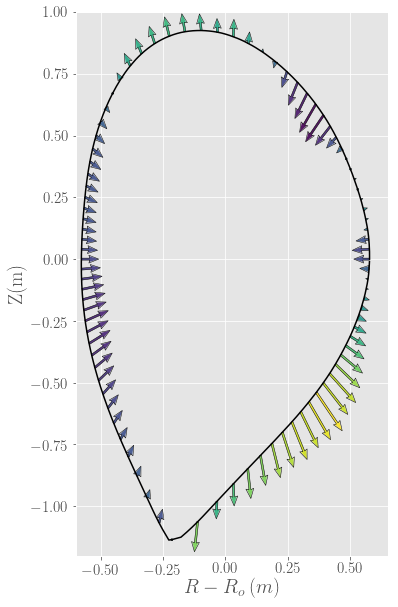

In [35]:
s_eq_gamma = P.smooth(eq_gamma,10)
'''Equilibrium ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Eqx,Eqy = eq_gamma*np.cos(new_an), eq_gamma*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], eq_gamma[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Eqx[::4], Eqy[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('Z(m)')
plt.xlim(-0.6,0.65)
plt.ylim(-1.2,1.0)
plt.axes().set_aspect(0.99)
plt.show()

In [56]:
'''Writing files for storage.'''
file = open("ti255_eq_arrow(fig2).txt",'a')
file.write("R"+"\t"+"Z"+"\t"+"Eqx"+"\t"+"Eqy"+"\n")
for i in range(len(R_s)):
    file.write(str(R_s[i])+"\t"+str(Z_s[i])+"\t"+str(Eqx[i])+"\t"+str(Eqy[i])+"\n")
file.close()    

In [36]:
'''Creates matrix of interpolations for turbulent quantities.'''
dpot_inter = np.asarray([])
dn_inter = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dpot_inter = np.append(dpot_inter,P.angle_interp(node_angles,dpot[:,plane,time],10,False))
        dn_inter = np.append(dn_inter,P.angle_interp(node_angles,dn[:,plane,time],10,False))

dpot_inter  = np.reshape(dpot_inter,(dpot.shape[2],dpot.shape[1],360))
dn_inter  = np.reshape(dn_inter,(dpot.shape[2],dpot.shape[1],360))

In [37]:
'''Creates matrix of derivatives.'''
dpotdth = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dpotdth = np.append(dpotdth,P.ddtheta_even(node_angles,dpot_inter[time,plane,:]))
        
dpotdth  = np.reshape(dpotdth,(dpot.shape[2],dpot.shape[1],360))

In [38]:
'''Creates matrix of velocities.'''
dv = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dv = np.append(dv,-(F*J_inv*B_factor*dpotdth[time, plane, :])/(R_Bp_B2))
dv = np.reshape(dv,(dpot.shape[2],dpot.shape[1],360))        

In [39]:
'''Creates matrixes of perturbation strengths'''
'''potential'''
dpot_rms = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dpot_rms = np.append(dpot_rms, np.power(dpot_inter[time, plane, :],2))

dpot_rms = np.reshape(dpot_rms,(dpot.shape[2],dpot.shape[1],360))
dpot_rms = np.mean(dpot_rms, axis=0)
dpot_rms = np.mean(dpot_rms,axis=0)
dpot_rms = np.sqrt(dpot_rms)

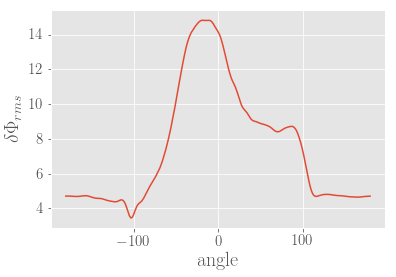

In [40]:
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dpot_rms[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"$\delta \Phi_{rms}$")
plt.show()

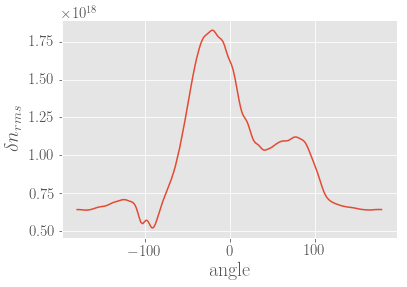

In [41]:
'''density'''
dn_rms = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dn_rms = np.append(dn_rms, np.power(dn_inter[time, plane, :],2))

dn_rms = np.reshape(dn_rms,(dpot.shape[2],dpot.shape[1],360))
dn_rms = np.mean(dn_rms, axis=0)
dn_rms = np.mean(dn_rms,axis=0)
dn_rms = np.sqrt(dn_rms)

plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dn_rms[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"$\delta n_{rms}$")
plt.show()

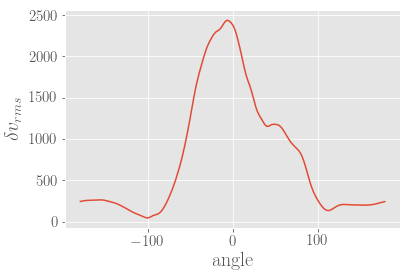

In [42]:
'''velocity'''
dv_rms = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        dv_rms = np.append(dv_rms, np.power(dv[time, plane, :],2))

dv_rms = np.reshape(dv_rms,(dpot.shape[2],dpot.shape[1],360))
dv_rms = np.mean(dv_rms, axis=0)
dv_rms = np.mean(dv_rms,axis=0)
dv_rms = np.sqrt(dv_rms)

plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dv_rms[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"$\delta v_{rms}$")
plt.show()

In [43]:
'''Creates matrix of fluxes.'''
gamma_turb = np.asarray([])
for time in range(0,dpot.shape[2]):
    for plane in range(0,dpot.shape[1]):
        gamma_turb = np.append(gamma_turb, dn_inter[time,plane,:]*dv[time,plane,:])
gamma_turb = np.reshape(gamma_turb,(dpot.shape[2],dpot.shape[1],360))
gamma_turb_tor = gamma_turb.mean(axis=1)
gamma_turb_avg = gamma_turb_tor.mean(axis=0)

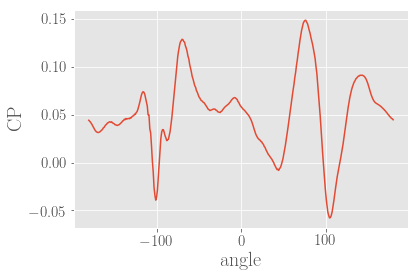

In [44]:
'''Cross-Phase'''
CP = gamma_turb_avg/(dn_rms*dv_rms)
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(CP[0:360],10),180))
plt.xlabel("angle")
plt.ylabel(r"CP")
plt.show()

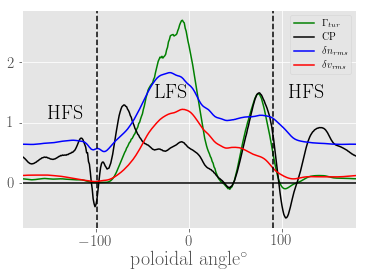

In [45]:
'''Turbulencec Strenghts'''
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(gamma_turb_avg[0:360],10)/1.e20,180), color = 'g',label=r'$\Gamma_{tur}$')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(CP[0:360],10)*10,180), color = 'k',label='CP')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dn_rms[0:360]/1.e18,10),180), color = 'b', label=r'$\delta n_{rms}$')
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(dv_rms[0:360],10)/2.e3,180), color = 'r', label=r'$\delta v_{rms}$')
plt.axvline(x=-99,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.4, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.xlim(-180,180)
plt.xlabel(r"poloidal angle$^{\circ}$")
plt.legend()
plt.show()

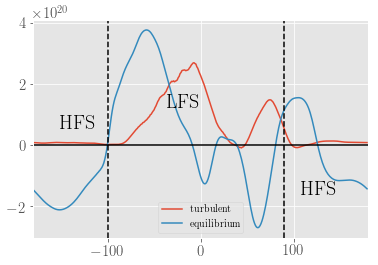

In [46]:
'''Comparison of fluxes.'''
plt.plot([x for x in range(-180,180)], np.roll(P.smooth(gamma_turb_avg[0:360],10),180),label='turbulent')
plt.plot([x for x in range(-180,180)],np.roll(P.smooth(eq_gamma,10),180),label='equilibrium')
plt.axvline(x=-99,color='k',linestyle='--')
plt.axvline(x=90,color='k',linestyle='--')
plt.axhline(y=0,color='k',linestyle='-')
plt.annotate('LFS', xy=(0.3,0.5),xytext=(0.4, 0.6),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.8, 0.2),textcoords='axes fraction')
plt.annotate('HFS', xy=(0.3,0.5),xytext=(0.08, 0.5),textcoords='axes fraction')
plt.xlim(-180,180)
plt.legend()
plt.show()

C:\Users\giannis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


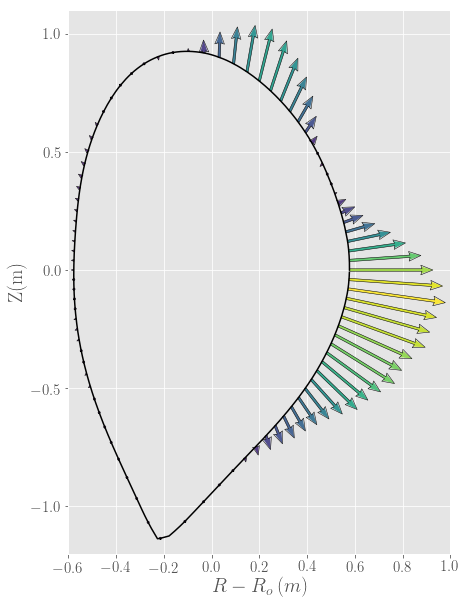

In [47]:
s_tur = P.smooth(gamma_turb_avg,10)
'''Turbulent ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Turx,Tury = s_tur*np.cos(new_an), s_tur*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s[::4], Z_s[::4], Turx[::4], Tury[::4], s_tur[::4], alpha=.9)
plt.quiver(R_s[::4], Z_s[::4], Turx[::4], Tury[::4], edgecolor='k', facecolor='None', linewidth=.5, headwidth = 4)
plt.plot(R_s,Z_s,'k-')
#plt.axhline(y=-0.78)
#plt.axhline(y=0.93)
#plt.axvline(x=0.15)
#plt.axvline(x=-0.08)
plt.xlabel(r'$R-R_o \,(m)$')
plt.ylabel('Z(m)')
plt.xlim(-0.6,1.0)
plt.ylim(-1.2,1.1)
plt.axes().set_aspect(0.99)
plt.show()

In [57]:
'''Writing files for storage.'''
file = open("ti255_tur_arrow(fig5).txt",'a')
file.write("R"+"\t"+"Z"+"\t"+"Turx"+"\t"+"Tury"+"\n")
for i in range(len(R_s)):
    file.write(str(R_s[i])+"\t"+str(Z_s[i])+"\t"+str(Turx[i])+"\t"+str(Tury[i])+"\n")
file.close()    

In [48]:
'''Writing fluxes on text files for easy retrieval.'''
#file = open("ti255_particle_exb_fluxes.txt",'a')
#file.write("Ang."+"\t"+"Eq."+"\t"+"Tur."+"\n")
#for i in range(len(angle)):
#    file.write(str(angle[i])+"\t"+str(s_eq_gamma[i])+"\t"+str(s_tur[i])+"\n")
#file.close()    

'Writing fluxes on text files for easy retrieval.'

C:\Users\giannis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


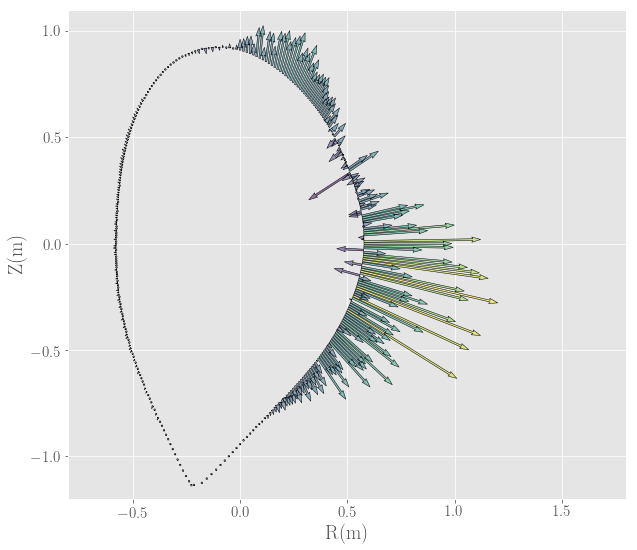

In [49]:
'''Turbulent ExB Flux.'''
new_an = np.arctan2(Z_s,R_s)
Turx,Tury = gamma_turb_avg*np.cos(new_an), gamma_turb_avg*np.sin(new_an)
plt.figure(figsize=(10,10))
plt.quiver(R_s, Z_s, Turx, Tury, gamma_turb_avg, alpha=.5)
plt.quiver(R_s, Z_s, Turx, Tury, edgecolor='k', facecolor='None', linewidth=.5)
plt.xlabel('R(m)')
plt.ylabel('Z(m)')
plt.xlim(-0.8,1.8)
plt.ylim(-1.2,1.1)
plt.axes().set_aspect(0.99)
plt.show()

In [50]:
'''Check to see if reshaping is working correctly.'''
fill = np.arange(24).reshape(6,4)
A = np.asarray([])
counter = 0
for time in range(0,2):
    for plane in range(0,3):
        A = np.append(A, fill[counter,:])
        counter = counter+1
A = np.reshape(A,(2,3,4))

### Integrals

In [51]:
'''Radii.'''
r_s,R_maj_s = P.major_R(R_s,Z_s)

In [52]:
'''Particle current accross the separatrix.'''
Equilibrium_Particle_Curr = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],Eq_dth[0:360])
Turbulent_Particle_Curr = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],gamma_turb_avg[0:360])
print("Equilibrium Particle current = ",Equilibrium_Particle_Curr)
print("Turbulent Particle current = ",Turbulent_Particle_Curr)
Smooth_Equilibrium_Particle_Curr = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq[0:360])
Smooth_Turbulent_Particle_Curr = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur[0:360])
print("Smooth Equilibrium Particle current = ",Smooth_Equilibrium_Particle_Curr)
print("Smooth Turbulent Particle current = ",Smooth_Turbulent_Particle_Curr)

Equilibrium Particle current =  1.1733249146808344e+21
Turbulent Particle current =  3.023465886594389e+21
Smooth Equilibrium Particle current =  1.0358116060920456e+21
Smooth Turbulent Particle current =  2.9810867375575075e+21


In [53]:
'''FSA <Q grad\psi>'''
normalization = P.Normalization(Bp[0:360],r_s[0:360],angle[0:360])
Equilibrium_grad_FSA = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],Eq_dth[0:360])/normalization
Turbulent_grad_FSA = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],gamma_turb_avg[0:360])/normalization
print("Equilibrium grad FSA = ",Equilibrium_grad_FSA)
print("Turbulent grad FSA = ",Turbulent_grad_FSA)
print("cancellation Equilibrium = ",Equilibrium_grad_FSA/max(Eq_dth))
print("cancellation Turbulent = ",Turbulent_grad_FSA/max(gamma_turb_avg))
Smooth_Equilibrium_grad_FSA = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_eq[0:360])/normalization
Smooth_Turbulent_grad_FSA = P.Tokamak_Integral(R_maj_s[0:360],r_s[0:360],angle[0:360],s_tur[0:360])/normalization
print("Smooth Equilibrium grad FSA = ",Smooth_Equilibrium_grad_FSA)
print("Smooth Turbulent grad FSA = ",Smooth_Turbulent_grad_FSA)
print("cancellation Smooth Equilibrium = ",Smooth_Equilibrium_grad_FSA/max(s_eq))
print("cancellation Smooth Turbulent = ",Smooth_Turbulent_grad_FSA/max(s_tur))

Equilibrium grad FSA =  9.135443286130289e+18
Turbulent grad FSA =  2.35405391881975e+19
cancellation Equilibrium =  0.02286930374952547
cancellation Turbulent =  0.04322502222142917
Smooth Equilibrium grad FSA =  8.064772224787715e+18
Smooth Turbulent grad FSA =  2.3210577463446938e+19
cancellation Smooth Equilibrium =  0.021739259544433613
cancellation Smooth Turbulent =  0.08615994347725199


In [54]:
'''FSA'''
normalization = P.Normalization(Bp[0:360],r_s[0:360],angle[0:360])
Equilibrium_FSA = P.FSA_Integral(Bp[0:360],r_s[0:360],angle[0:360],Eq_dth[0:360])/normalization
Turbulent_FSA = P.FSA_Integral(Bp[0:360],r_s[0:360],angle[0:360],gamma_turb_avg[0:360])/normalization
print("Equilibrium FSA = ",Equilibrium_FSA)
print("Turbulent FSA = ",Turbulent_FSA)
print("cancellation Equilibrium = ",Equilibrium_FSA/max(Eq_dth))
print("cancellation Turbulent = ",Turbulent_FSA/max(gamma_turb_avg))
Smooth_Equilibrium_FSA = P.FSA_Integral(Bp[0:360],r_s[0:360],angle[0:360],s_eq[0:360])/normalization
Smooth_Turbulent_FSA = P.FSA_Integral(Bp[0:360],r_s[0:360],angle[0:360],s_tur[0:360])/normalization
print("Smooth Equilibrium FSA = ",Smooth_Equilibrium_FSA)
print("Smooth Turbulent FSA = ",Smooth_Turbulent_FSA)
print("cancellation Smooth Equilibrium = ",Smooth_Equilibrium_FSA/max(s_eq))
print("cancellation Smooth Turbulent = ",Smooth_Turbulent_FSA/max(s_tur))

Equilibrium FSA =  2.0510017946509287e+19
Turbulent FSA =  2.890916120403138e+19
cancellation Equilibrium =  0.05134395952510212
cancellation Turbulent =  0.05308285954952319
Smooth Equilibrium FSA =  1.0732780875752724e+19
Smooth Turbulent FSA =  2.9162608010890113e+19
cancellation Smooth Equilibrium =  0.02893109719508087
cancellation Smooth Turbulent =  0.10825446552652904


In [55]:
'''Cancellation test'''
test = np.ones(360)
test_FSA = P.FSA_Integral(Bp[0:360],r_s[0:360],angle[0:360],test[0:360])/normalization
print("test_FSA =", test_FSA)
print("test_cancellation = ", test_FSA/max(test))

test_FSA = 1.0
test_cancellation =  1.0
